In [1]:
import numpy as np
import unicodedata
import re
import os
import io
import sys
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense

In [2]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [3]:
!unzip /content/pes-eng.zip

unzip:  cannot find or open /content/pes-eng.zip, /content/pes-eng.zip.zip or /content/pes-eng.zip.ZIP.


In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<sos> ' + w + ' <eos>'
    return w

In [5]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [6]:
def tokenize(lang):
    tokenizer = Tokenizer(filters='')

    tokenizer.fit_on_texts(lang)

    tensor = tokenizer.texts_to_sequences(lang)
    tensor = pad_sequences(tensor, padding='post')

    return tokenizer, tensor

def load_dataset(path, num_examples):
    target_data, input_data = create_dataset(path, num_examples)

    input_tokenizer, input_tensor = tokenize(input_data)
    target_tokenizer, target_tensor = tokenize(target_data)

    return input_tensor, target_tensor, input_tokenizer, target_tokenizer

In [7]:
num_examples = 30000

input_tensor, target_tensor, input_tokenizer, target_tokenizer = load_dataset(path_to_file, num_examples)

inp_length, trg_length = input_tensor.shape[1], target_tensor.shape[1]

print(f'input shape: {input_tensor.shape}')
print(f'target shape: {target_tensor.shape}')
print(f'input vocab size: {len(input_tokenizer.word_index):,}')
print(f'target vocab size: {len(target_tokenizer.word_index):,}')

input shape: (30000, 16)
target shape: (30000, 11)
input vocab size: 9,413
target vocab size: 4,934


In [8]:
BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
embedding_dim = 256
units = 1024
EPOCHS = 10
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

In [9]:
# build dataset
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: ((64, 16), (64, 11)), types: (tf.int32, tf.int32)>


In [10]:
# encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()

        self.batch_size = batch_size
        self.enc_units = enc_units

        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)

        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [11]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [12]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [13]:
# bahdanau attention
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
    
    def call(self, query, values):
        query_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(self.W1(query_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [14]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()

        self.batch_size = batch_size
        self.dec_units = dec_units
        
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

        self.fc = Dense(vocab_size)

        # add attention
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [17]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_obj(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [19]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_tokenizer.word_index['<sos>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [20]:
def print_loss(loss, step, all_step, second, times):
    d_step = step//10
    d_all_step = all_step//10
    sys.stdout.write("\r" + f"{step}/{all_step} " + '[' + '='*d_step + '>' + '.'*(d_all_step-d_step) + ']' + " - " + f'{round(time.time()-times)}s' + " - " +\
                     f'{round(second)}s/step' + " - " + "loss: {:.3}".format(loss))

    if step == all_step:
        times = time.time() - times
        sys.stdout.write("\r" + f"{step}/{all_step} " + '[' + '='*d_step + ']' + " - " + f'{round(times)}s' +\
                        " - " + f'{round(second)}s/step' + " - " + "loss: {:.3}\n".format(loss))

In [21]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    start = time.time()
    epoch_log = 0

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        s = time.time()

        batch_loss = train_step(inp, targ, enc_hidden)
        print_loss(batch_loss, batch+1, len(dataset), epoch_log, start)

        total_loss += batch_loss

        # if batch % 100 == 0:
        #     print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

        epoch_log = time.time() - s

    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    # print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    # print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1/10
468/468 [==============================================] - 49s - 0s/step - loss: 1.48
Epoch 2/10
468/468 [==============================================] - 39s - 0s/step - loss: 0.864
Epoch 3/10
468/468 [==============================================] - 40s - 0s/step - loss: 0.701
Epoch 4/10
468/468 [==============================================] - 40s - 0s/step - loss: 0.483
Epoch 5/10
468/468 [==============================================] - 40s - 0s/step - loss: 0.449
Epoch 6/10
468/468 [==============================================] - 40s - 0s/step - loss: 0.245
Epoch 7/10
468/468 [==============================================] - 40s - 0s/step - loss: 0.172
Epoch 8/10
468/468 [==============================================] - 40s - 0s/step - loss: 0.133
Epoch 9/10
468/468 [==============================================] - 40s - 0s/step - loss: 0.116
Epoch 10/10
468/468 [==============================================] - 40s - 0s/step - loss: 0.0826


In [22]:
def evaluate(sentence):
    attention_plot = np.zeros((trg_length, inp_length))

    sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = pad_sequences([inputs], maxlen=inp_length, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<sos>']], 0)

    for t in range(trg_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id]

        if target_tokenizer.index_word[predicted_id] == '<eos>':
            return result, sentence, attention_plot
        
        else:
            result += ' '

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [23]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [24]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [25]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <sos> hace mucho frio aqui . <eos>
Predicted translation: it s very cold here . <eos>


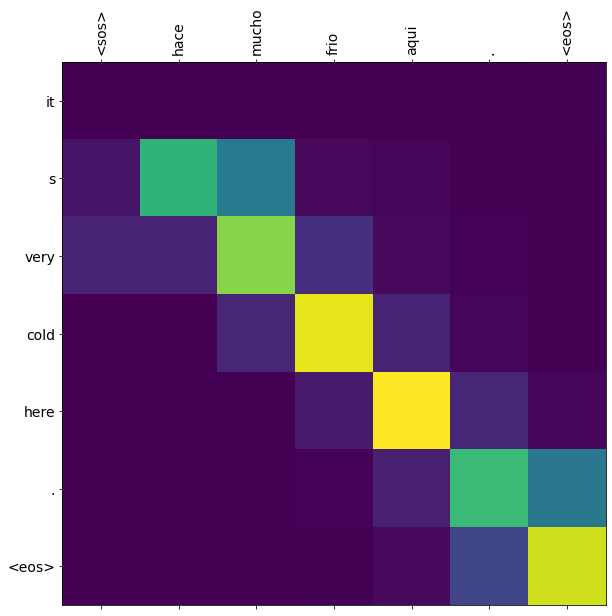

In [26]:
translate(u'hace mucho frio aqui.')